In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [26]:
df = pd.read_csv('data/df_final.csv')

In [27]:
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

df['NumTotalPurchases'] = df['NumDealsPurchases'] + df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases']

from sklearn.feature_selection import VarianceThreshold

X = df_imputed.drop(columns=['cluster', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumDealsPurchases', 'MntGoldProds' ])
y = df_imputed['cluster']

# Remove constant features
constant_filter = VarianceThreshold(threshold=0)
X_filtered = constant_filter.fit_transform(X)

selector = SelectKBest(score_func=f_classif, k=2)
X_selected = selector.fit_transform(X_filtered, y)
selected_features = X.columns[constant_filter.get_support()][selector.get_support()]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

models = {
    'RandomForest': RandomForestClassifier(),
    'LogisticRegression': LogisticRegression(),
    'SVC': SVC(),
    'KNeighbors': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier()
}

print("Selected features:", selected_features)

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Model: {name}")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

Selected features: Index(['Income', 'TotalMnt'], dtype='object')
Model: RandomForest
              precision    recall  f1-score   support

         0.0       0.85      0.84      0.84       110
         1.0       0.81      0.78      0.79       117
         2.0       0.95      0.98      0.97       216

    accuracy                           0.89       443
   macro avg       0.87      0.87      0.87       443
weighted avg       0.89      0.89      0.89       443

[[ 92  18   0]
 [ 16  91  10]
 [  0   4 212]]
Model: LogisticRegression
              precision    recall  f1-score   support

         0.0       0.82      0.81      0.81       110
         1.0       0.78      0.75      0.77       117
         2.0       0.95      0.97      0.96       216

    accuracy                           0.87       443
   macro avg       0.85      0.84      0.85       443
weighted avg       0.87      0.87      0.87       443

[[ 89  21   0]
 [ 18  88  11]
 [  2   4 210]]
Model: SVC
              precision 

In [28]:
param_grid = {
    'RandomForest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30]
    },
    'LogisticRegression': {
        'C': [0.1, 1, 10],
        'solver': ['liblinear']
    },
    'SVC': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    'KNeighbors': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    },
    'DecisionTree': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }
}

best_models = {}
for name, model in models.items():
    grid_search = GridSearchCV(model, param_grid[name], cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    print(f"Model: {name}")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

Best parameters for RandomForest: {'max_depth': None, 'n_estimators': 200}
Best parameters for LogisticRegression: {'C': 10, 'solver': 'liblinear'}
Best parameters for SVC: {'C': 1, 'kernel': 'rbf'}
Best parameters for KNeighbors: {'n_neighbors': 7, 'weights': 'uniform'}
Best parameters for DecisionTree: {'max_depth': 10, 'min_samples_split': 2}
Model: RandomForest
              precision    recall  f1-score   support

         0.0       0.85      0.85      0.85       110
         1.0       0.82      0.77      0.79       117
         2.0       0.95      0.99      0.97       216

    accuracy                           0.89       443
   macro avg       0.87      0.87      0.87       443
weighted avg       0.89      0.89      0.89       443

[[ 93  17   0]
 [ 16  90  11]
 [  0   3 213]]
Model: LogisticRegression
              precision    recall  f1-score   support

         0.0       0.77      0.93      0.84       110
         1.0       0.88      0.62      0.72       117
         2.0    

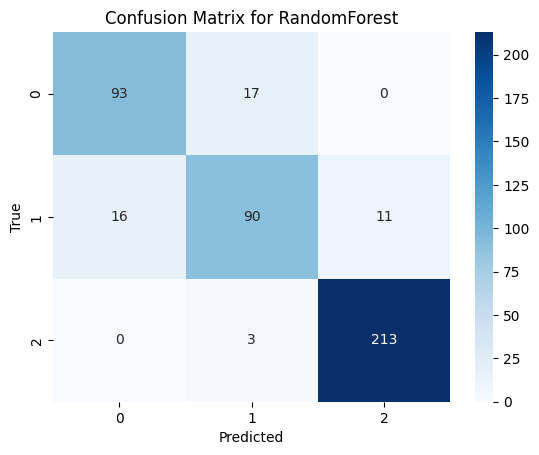

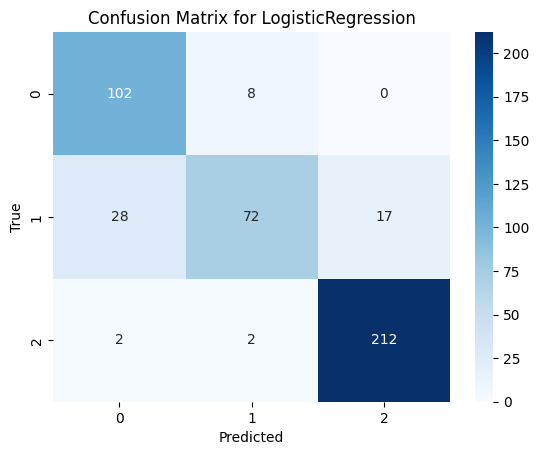

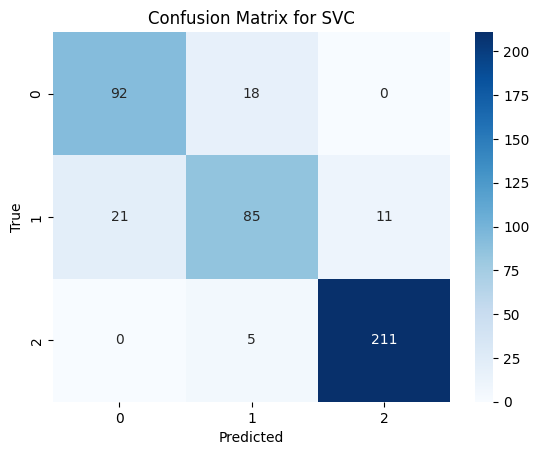

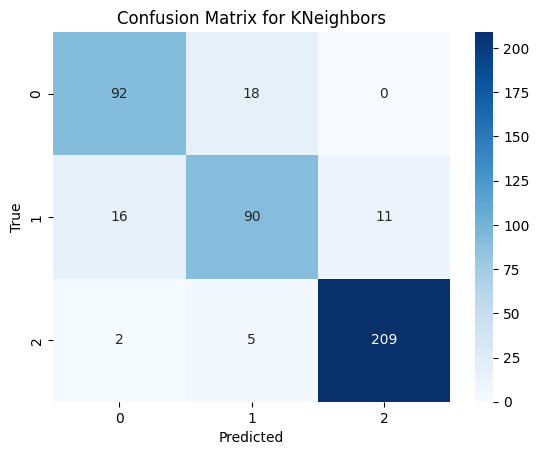

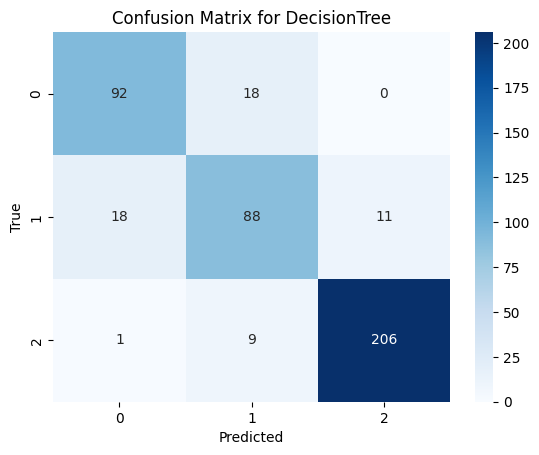

In [29]:
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [30]:
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    print(f"Classification Report for {name}")
    print(classification_report(y_test, y_pred))

Classification Report for RandomForest
              precision    recall  f1-score   support

         0.0       0.85      0.85      0.85       110
         1.0       0.82      0.77      0.79       117
         2.0       0.95      0.99      0.97       216

    accuracy                           0.89       443
   macro avg       0.87      0.87      0.87       443
weighted avg       0.89      0.89      0.89       443

Classification Report for LogisticRegression
              precision    recall  f1-score   support

         0.0       0.77      0.93      0.84       110
         1.0       0.88      0.62      0.72       117
         2.0       0.93      0.98      0.95       216

    accuracy                           0.87       443
   macro avg       0.86      0.84      0.84       443
weighted avg       0.88      0.87      0.87       443

Classification Report for SVC
              precision    recall  f1-score   support

         0.0       0.81      0.84      0.83       110
         1.0   

In [31]:
# Obter o modelo RandomForest do dicionário de melhores modelos
rf_model = best_models['RandomForest']

# Obter as importâncias das features
importances = rf_model.feature_importances_

# Criar um DataFrame para visualizar as importâncias das features
feature_importances = pd.DataFrame({'Feature': selected_features, 'Importance': importances})

# Ordenar as importâncias das features em ordem decrescente
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print(feature_importances)

    Feature  Importance
1  TotalMnt    0.537966
0    Income    0.462034


In [32]:
correlation = df['TotalMnt'].corr(df['Income'])
print(f"Correlação entre TotalMnt e Income: {correlation}")

Correlação entre TotalMnt e Income: 0.6675161589034099


---

In [33]:
from sklearn.pipeline import Pipeline

df = pd.read_csv('data/df_final.csv')

X = df

# Definir a variável y
y = df['Response']

# Remover as colunas especificadas
columns_to_drop = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 
                   'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumDealsPurchases', 'MntGoldProds', 'Response']
X_dropped = X.drop(columns=columns_to_drop)

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_dropped, y, test_size=0.2, random_state=42)

# Criar um pipeline com imputação, escalonamento, remoção de features constantes, seleção de features e o modelo
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('variance_threshold', VarianceThreshold()),  # Remove constant features
    ('selector', SelectKBest(score_func=f_classif, k=15)),
    ('classifier', RandomForestClassifier(random_state=42, class_weight={0: 1, 1: 10}))  # Ajuste os pesos conforme necessário
])

# Definir a grade de parâmetros para validação cruzada
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10]
}

# Aplicar validação cruzada e ajuste de hiperparâmetros
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Melhor modelo
best_model = grid_search.best_estimator_

# Avaliar o modelo no conjunto de teste
y_pred = best_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Imprimir as features selecionadas
variance_threshold_support = best_model.named_steps['variance_threshold'].get_support()
selected_features = X_dropped.columns[variance_threshold_support][best_model.named_steps['selector'].get_support()]
print("Selected features:", selected_features)


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       363
           1       0.70      0.50      0.58        80

    accuracy                           0.87       443
   macro avg       0.80      0.73      0.75       443
weighted avg       0.86      0.87      0.86       443

Confusion Matrix:
[[346  17]
 [ 40  40]]
Selected features: Index(['Income', 'Kidhome', 'Teenhome', 'Recency', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'TotalMnt', 'Education_PhD', 'Marital_Status_Married',
       'Marital_Status_Single', 'Marital_Status_Together', 'cluster'],
      dtype='object')


In [38]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

df = pd.read_csv('data/df_final.csv')

X = df

# Definir a variável y
y = df['Response']

# Remover as colunas especificadas
columns_to_drop = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 
                   'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumDealsPurchases', 'MntGoldProds']
X_dropped = X.drop(columns=columns_to_drop)

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_dropped, y, test_size=0.2, random_state=42)

# Criar um pipeline com imputação, escalonamento, remoção de features constantes, seleção de features e o modelo
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('variance_threshold', VarianceThreshold()),  # Remove constant features
    ('selector', SelectKBest(score_func=f_classif, k=10)),
    ('classifier', AdaBoostClassifier(estimator=RandomForestClassifier(random_state=42, class_weight={0: 1, 1: 10}), algorithm='SAMME', random_state=42))
])

# Definir a grade de parâmetros para validação cruzada
param_grid = {
    'classifier__estimator__n_estimators': [50, 100, 200],
    'classifier__estimator__max_depth': [None, 10, 20, 30],
    'classifier__estimator__min_samples_split': [2, 5, 10],
    'classifier__n_estimators': [50, 100, 200]
}

# Aplicar validação cruzada e ajuste de hiperparâmetros
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Melhor modelo
best_model = grid_search.best_estimator_

# Avaliar o modelo no conjunto de teste
y_pred = best_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Imprimir as features selecionadas
variance_threshold_support = best_model.named_steps['variance_threshold'].get_support()
selected_features = X_dropped.columns[variance_threshold_support][best_model.named_steps['selector'].get_support()]
print("Selected features:", selected_features)

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       363
           1       0.75      0.38      0.50        80

    accuracy                           0.86       443
   macro avg       0.81      0.67      0.71       443
weighted avg       0.85      0.86      0.85       443

Confusion Matrix:
[[353  10]
 [ 50  30]]
Selected features: Index(['Teenhome', 'Recency', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'TotalMnt', 'Marital_Status_Single',
       'cluster'],
      dtype='object')


---

In [39]:
# Adicionar a coluna 'acceptedtotalcmp'
df['acceptedtotalcmp'] = df[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']].sum(axis=1)

# Selecionar as features e a target
X = df.drop(columns=['acceptedtotalcmp', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'TotalMnt'])  # Remova outras colunas irrelevantes se necessário
y = df['acceptedtotalcmp']

# Remover features constantes
constant_filter = VarianceThreshold(threshold=0)
X_filtered = constant_filter.fit_transform(X)

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=42)

# Selecionar as melhores features
selector = SelectKBest(score_func=f_classif, k=15)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Inicializar o modelo
rf_model = RandomForestClassifier(random_state=42)

# Treinar o modelo
rf_model.fit(X_train_selected, y_train)

# Fazer previsões
y_pred = rf_model.predict(X_test_selected)

# Imprimir o relatório de classificação
print(classification_report(y_test, y_pred))

# Obter as importâncias das features
importances = rf_model.feature_importances_

# Criar um DataFrame para visualizar as importâncias das features
selected_features = X.columns[constant_filter.get_support()][selector.get_support()]
feature_importances = pd.DataFrame({'Feature': selected_features, 'Importance': importances})

# Ordenar as importâncias das features em ordem decrescente
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print(feature_importances)
# Definir pesos maiores para os valores preditos maiores que 0
class_weights = {0: 1, 1: 5, 2: 5}

# Inicializar o modelo com os pesos definidos
rf_model_weighted = RandomForestClassifier(random_state=42, class_weight=class_weights)

# Treinar o modelo
rf_model_weighted.fit(X_train_selected, y_train)

# Fazer previsões
y_pred_weighted = rf_model_weighted.predict(X_test_selected)

# Imprimir o relatório de classificação
print(classification_report(y_test, y_pred_weighted))

# Obter as importâncias das features
importances_weighted = rf_model_weighted.feature_importances_

# Criar um DataFrame para visualizar as importâncias das features
feature_importances_weighted = pd.DataFrame({'Feature': selected_features, 'Importance': importances_weighted})

# Ordenar as importâncias das features em ordem decrescente
feature_importances_weighted = feature_importances_weighted.sort_values(by='Importance', ascending=False)

print(feature_importances_weighted)

              precision    recall  f1-score   support

           0       0.85      0.99      0.91       339
           1       0.57      0.26      0.35        66
           2       0.56      0.28      0.37        18
           3       0.56      0.36      0.43        14
           4       0.00      0.00      0.00         6

    accuracy                           0.82       443
   macro avg       0.51      0.38      0.41       443
weighted avg       0.77      0.82      0.78       443

                Feature  Importance
2              MntWines    0.146673
0                Income    0.114417
4       MntMeatProducts    0.100258
7          MntGoldProds    0.086377
5       MntFishProducts    0.073088
3             MntFruits    0.069690
6      MntSweetProducts    0.069690
10  NumCatalogPurchases    0.067174
11    NumStorePurchases    0.053373
9       NumWebPurchases    0.053133
13             Response    0.050223
12    NumWebVisitsMonth    0.046539
8     NumDealsPurchases    0.036883
14     

c:\Users\victo\OneDrive\Documents\GitHub\customer-segmentation-analysis\notebook\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\victo\OneDrive\Documents\GitHub\customer-segmentation-analysis\notebook\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\victo\OneDrive\Documents\GitHub\customer-segmentation-analysis\notebook\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pr